In [1]:
# The ultimate target feature: time from one stop to another

# Imports
import pandas as pd
import numpy as np
from datetime import date, datetime
from patsy import dmatrices
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import export_graphviz, DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib 
from statsmodels.formula.api import ols

# Read csv file into a dataframe.
df = pd.read_csv('csv_data/route4.csv')

/Users/katerooney/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1.0 Data Cleaning 

## 1.1 Rename column names

In [2]:
df = df.rename(columns={'Timeframe': 'Start_date'})

## 1.2 Dropping duplicates

In [3]:
df=df.drop_duplicates(keep='first')

## 1.3 Dropping constant columns or columns with missing data

In [4]:
df = df.drop('Direction', axis=1)
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('Congestion', axis=1)
df[df.Journey_Pattern_ID == 'null']
df = df[df['Journey_Pattern_ID'] != '00040002']
df = df[df['Journey_Pattern_ID'] != '00041002']

## 1.4 Remove rows where bus is not at stop

In [5]:
df = df.loc[(df != 0).all(axis=1), :]

## 1.5 Group to normalise time & remove rows where bus idle at stop

In [6]:
# Create empty column which will hold normalised time
df['normal_time'] = 0

In [7]:
# Create empty column which will hold the stop order
df['stop_order'] = 0

In [8]:
grouped_df = df.groupby(['Vehicle_Journey_ID', 'Start_date'])

In [9]:
def normalize_time(df):
    """Normalise the time for each journey"""
    for i in range(df['Timestamp'].size):
        df['normal_time'].values[i] = (df['Timestamp'].values[i] - df['Timestamp'].values[0]) / 1000000
        
    return df

In [10]:
norm_gb = grouped_df.apply(normalize_time)

In [11]:
grouped_df = norm_gb.groupby(['Vehicle_Journey_ID', 'Start_date'])

In [12]:
def remove_idle_at_stop(df):
    df = df.drop_duplicates(subset='Stop_ID', keep='first')
    
    return df

In [13]:
norm_gb = grouped_df.apply(remove_idle_at_stop)

In [14]:
grouped_df = norm_gb.groupby(['Vehicle_Journey_ID', 'Start_date'])

/Users/katerooney/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'Vehicle_Journey_ID' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.
/Users/katerooney/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'Start_date' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


In [15]:
def route_order(df):
    for i in range(df['Timestamp'].size):
        df['stop_order'].values[i] = i+1
    
    return df

In [16]:
df = grouped_df.apply(route_order)

In [17]:
grouped_df = df.groupby(['Vehicle_Journey_ID', 'Start_date'])

/Users/katerooney/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'Vehicle_Journey_ID' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.
/Users/katerooney/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'Start_date' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


In [18]:
#removed crystallising end stop as take that out later on - for flexibility to run checks beforehand
#have to add stops near the beginning as just the first stop is not capturing all journies, drivers must not be setting the 
#vehicle journey ID before starting off
def stop_start_only(df):
    if ( (df['Stop_ID'][0] == '7330') | (df['Stop_ID'][0] == '7113') | (df['Stop_ID'][0] == '324') | (df['Stop_ID'][0] == '327') | (df['Stop_ID'][0] == '2051')| (df['Stop_ID'][0] == '6086')):
                                                                        
        df['full_trip'] = 1
    return df

In [19]:
df = grouped_df.apply(stop_start_only)

In [20]:
df = df.loc[df['full_trip'] == 1]

## 1.6 Add new features

In [21]:
df["Time"] = pd.to_datetime(df['Timestamp']*1000, unit="ns")

In [22]:
df['IsWeekend'] = np.where((df['Time'].dt.dayofweek > 4), 1, 0)
# df = df.loc[df['IsWeekend'] != 1]

In [23]:
df['HourOfDay'] = df['Time'].dt.hour

In [24]:
df['MinsOfHour'] = df['Time'].dt.minute
df['MinsOfHour30'] = np.where((df['MinsOfHour'] > 30), 1, 0)
df['MinsOfHour15'] = np.where((df['MinsOfHour'] > 15), 1, 0)
df['MinsOfHour45'] = np.where((df['MinsOfHour'] > 45), 1, 0)

In [25]:
df['Time_bin_xxx'] =df.HourOfDay.astype('str') + df.MinsOfHour15.astype('str')+ df.MinsOfHour30.astype('str') + df.MinsOfHour45.astype('str')
df['Time_bin_xxx']=df['Time_bin_xxx'].astype('int')


In [26]:
df['before_end'] = np.where(((df['Time_bin_xxx'] >= 22000) & (df['Time_bin_xxx'] <= 23001)), 1, 0)

In [27]:
df['before_tenPM'] = np.where(((df['Time_bin_xxx'] >= 18000) & (df['Time_bin_xxx'] <= 22000)), 1, 0)

In [28]:
df['before_six'] = np.where(((df['Time_bin_xxx'] >= 16000) & (df['Time_bin_xxx'] <= 18000)), 1, 0)

In [29]:
df['before_four'] = np.where(((df['Time_bin_xxx'] >= 11000) & (df['Time_bin_xxx'] <= 16000)), 1, 0)

In [30]:
df['before_eleven'] = np.where(((df['Time_bin_xxx'] >= 9000) & (df['Time_bin_xxx'] <= 11000)), 1, 0)

In [31]:
df['before_nine'] = np.where(((df['Time_bin_xxx'] >= 6000) & (df['Time_bin_xxx'] <= 9000)), 1, 0)

In [32]:
df['DayOfWeek'] = df['Time'].dt.dayofweek

In [33]:
df['IsEveningTime'] = np.where((df['Time'].dt.hour > 17), 1, 0)

In [34]:
df['Direction_north'] = np.where((df['Journey_Pattern_ID'] == '00041001'), 1,0)

In [35]:
df['RDS_Event'] = np.where((df['Time'].dt.date == datetime(2013, 1, 27).date()), 1, 0)

In [36]:
df['BankHoliday'] = np.where((df['Time'].dt.date == datetime(2013, 1, 1).date()), 1, 0)

In [37]:
df['SchoolHoliday'] = np.where((df['Time'].dt.date == datetime(2012, 11, 1).date()) | (

df['Time'].dt.date == datetime(2012, 11, 2).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 1).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 2).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 3).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 4).date()), 1, 0)

# 2.0 Merge Datasets

## 2.1 Merge bus stop info

df_bus_stop = pd.read_csv('csv_data/busstopinfo.csv', encoding='latin-1')

In [38]:
df.Stop_ID.unique()

array(['2051', '6086', '3162', '3163', '3084', '472', '473', '4705', '475',
       '478', '483', '485', '487', '488', '491', '493', '494', '495',
       '400', '281', '6', '195', '198', '148', '28', '322', '332', '3161',
       '3164', '477', '479', '490', '199', '200', '4680', '94', '469',
       '489', '194', '201', '476', '482', '7330', '471', '480', '93',
       '6182', '470', '492', '196', '126', '197', '27', '150', '7113',
       '127', '112', '115', '37', '40', '184', '186', '187', '188', '4725',
       '273', '402', '405', '411', '414', '415', '416', '420', '422',
       '428', '6334', '7226', '2026', '38', '39', '146', '190', '191',
       '819', '409', '410', '427', '3114', '6085', '113', '408', '412',
       '417', '418', '424', '425', '3115', '324', '147', '7457', '114',
       '185', '429', '413', '421', '419', '3116', '426', '189', '423',
       '149', '91', '481', '92', 190, 819, 4725, 273, 402, 405, 410, 416,
       417, 419, 421, '90', '29', '323', '327', 429, 3115, 60

In [39]:
df_all_routes = pd.read_csv('csv_data/Route_4_stops.csv', encoding='latin-1')
df_all_routes.shape

(118, 8)

df_bus_stop = df_bus_stop.rename(columns={'stopid': 'Stop_ID'})
df_bus_stop = df_bus_stop.rename(columns={'fullname': 'Stop_name'})

df_bus_stop = df_bus_stop[['Stop_ID', 'Stop_name']]

In [40]:
df_all_routes['Stop_ID']=df_all_routes['Stop_ID'].astype('str')
df_all_routes.Stop_ID.unique()

array(['324', '327', '7113', '127', '112', '113', '114', '115', '37', '38',
       '39', '40', '146', '147', '184', '185', '186', '187', '188', '189',
       '190', '191', '819', '260', '4725', '273', '402', '405', '408',
       '409', '410', '411', '412', '413', '414', '415', '416', '417',
       '418', '419', '420', '421', '422', '423', '424', '425', '426',
       '427', '428', '429', '6334', '3114', '3115', '3116', '6085', '2026',
       '7226', '7330', '2051', '6086', '3161', '3162', '3163', '3164',
       '3084', '469', '470', '471', '472', '473', '4705', '475', '476',
       '477', '478', '479', '480', '481', '482', '483', '485', '487',
       '488', '489', '490', '491', '492', '493', '494', '495', '400',
       '281', '6', '194', '195', '196', '197', '198', '199', '200', '201',
       '148', '149', '150', '27', '28', '29', '4680', '90', '91', '92',
       '93', '94', '126', '6182', '322', '323', '332'], dtype=object)

In [41]:
df_routes = df_all_routes[['Stop_ID','Stop_name','Stop_sequence']]
df_routes

,Stop_ID,Stop_name,Stop_sequence
0,324,Bus Garage,1
1,327,Silloge Golf Club,2
2,7113,Santry Avenue,3
3,127,St. Pappin's Road,4
4,112,Silloge Road,5
5,113,Nursing Home,6
6,114,Shanliss Road,7
7,115,Glasnevin Avenue,8
8,37,DCU,9
9,38,Hamstead Avenue,10


df = pd.merge(df, df_bus_stop, on=['Stop_ID'])
df.head()

In [42]:
df = pd.merge(df, df_routes, on=['Stop_ID'])
df.Stop_ID.unique()

array(['2051', '6086', '3162', '3163', '3084', '472', '473', '4705', '475',
       '478', '483', '485', '487', '488', '491', '493', '494', '495',
       '400', '281', '6', '195', '198', '148', '28', '322', '332', '3161',
       '3164', '477', '479', '490', '199', '200', '4680', '94', '469',
       '489', '194', '201', '476', '482', '7330', '471', '480', '93',
       '6182', '470', '492', '196', '126', '197', '27', '150', '7113',
       '127', '112', '115', '37', '40', '184', '186', '187', '188', '4725',
       '273', '402', '405', '411', '414', '415', '416', '420', '422',
       '428', '6334', '7226', '2026', '38', '39', '146', '190', '191',
       '819', '409', '410', '427', '3114', '6085', '113', '408', '412',
       '417', '418', '424', '425', '3115', '324', '147', '114', '185',
       '429', '413', '421', '419', '3116', '426', '189', '423', '149',
       '91', '481', '92', '90', '29', '323', '327'], dtype=object)

In [43]:
grouped_df = df.groupby(['Vehicle_Journey_ID', 'Start_date'])

grouped_df.get_group((4558, '2013-01-03'))

grouped_df.get_group((4542, '2013-01-15'))

In [44]:
df.shape

(37033, 38)

## 2.2 Merge weather data

In [45]:
df_weather = pd.read_csv('csv_data/weather_data.csv', encoding='latin-1')

In [46]:
df_weather = df_weather.rename(columns={'Rainfall (Yes or No)': 'Rain'})
df_weather = df_weather.rename(columns={'Temperature C': 'Temperature'})
df_weather = df_weather.rename(columns={'Relative Humidity (%)': 'Humidity'})
df_weather = df_weather.rename(columns={'Over 1mm Rain?': 'Heavy_rain'})
df_weather = df_weather.rename(columns={'Precipitation (mm)': 'Precipitation'})
df_weather = df_weather.rename(columns={'Date': 'Time'})
df_weather['Time'] = pd.to_datetime(df_weather['Time'])
df_weather.sort_values(['Time'], ascending=[True], inplace=True)
df_weather['HourOfDay'] = df_weather['Time'].dt.hour

In [47]:
df.sort_values(['Time'], ascending=[True], inplace=True)
df_weather.sort_values(['Time'], ascending=[True], inplace=True)
df =  pd.merge_asof(df, df_weather, on='Time')

In [48]:
#code from here: https://stackoverflow.com/questions/27313647/merging-two-pandas-dataframes-results-in-duplicate-columns

def drop_y(df):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)

drop_y(df)
df.columns

Index(['At_Stop', 'Block_ID', 'Delay', 'Journey_Pattern_ID', 'Lat', 'LineID',
       'Lon', 'Operator', 'Start_date', 'Stop_ID', 'Timestamp', 'Vehicle_ID',
       'Vehicle_Journey_ID', 'full_trip', 'normal_time', 'stop_order', 'Time',
       'IsWeekend', 'HourOfDay_x', 'MinsOfHour', 'MinsOfHour30',
       'MinsOfHour15', 'MinsOfHour45', 'Time_bin_xxx', 'before_end',
       'before_tenPM', 'before_six', 'before_four', 'before_eleven',
       'before_nine', 'DayOfWeek', 'IsEveningTime', 'Direction_north',
       'RDS_Event', 'BankHoliday', 'SchoolHoliday', 'Stop_name',
       'Stop_sequence', 'Precipitation', 'Temperature',
       'Vapour Pressure (hPa)                ', 'Humidity',
       'Mean Sea Level Pressure (hPa)', 'Rain', 'Heavy_rain'],
      dtype='object')

In [49]:
def rename_x(df):
    for col in df:
        if col.endswith('_x'):
            df.rename(columns={col:col.rstrip('_x')}, inplace=True)
rename_x(df)

df['Proper_rain'] = np.where(((df['Precipitation'] < 2.3) & (df['Precipitation'] > 1.7) & (df['IsPeakTime']==1)), 1, 0)

# 3.0 Remove and categories columns

## 3.1 Drop missing values

In [50]:
df = df[df['Journey_Pattern_ID'] != 'null']

## 3.2 Categorise to continuous and categorical

In [51]:
continuous_columns = df.select_dtypes(['int64', 'float64']).columns

## 3.3 Drop columns no longer needed

In [52]:
df = df.drop('Lat', axis=1)
df = df.drop('Lon', axis=1)
df = df.drop('Block_ID', axis=1)
df = df.drop('Operator', axis=1)

## 3.4 Create time to destination feature

In [53]:
df['end_time'] = df.groupby(['Vehicle_Journey_ID', 'Start_date'])['Timestamp'].transform(max)

In [54]:
df['start_time'] = df.groupby(['Vehicle_Journey_ID', 'Start_date'])['Timestamp'].transform(min)

In [55]:
df['start_stop'] = df.groupby(['Vehicle_Journey_ID', 'Start_date'])['Stop_sequence'].transform(min)

In [56]:
df['max_stop_sequence'] = df.groupby(['Direction_north'])['Stop_sequence'].transform(max)

In [57]:
df['end_stop'] = df.groupby(['Vehicle_Journey_ID', 'Start_date'])['Stop_sequence'].transform(max)

In [58]:
df['stops_travelled'] = ((df['end_stop'] - df['start_stop']) )

In [59]:
df['scheduled__overall_journey_time']=60

In [60]:
df['late'] = ((df['end_time'] - df['start_time']) )
df['time_travelling'] = ((df['Timestamp'] - df['start_time']) )
df['time_to_travel'] = ((df['end_time'] - df['Timestamp'] ) )
df['time_travelling'] = pd.to_timedelta(df['time_travelling']*1000, unit="ns").astype('timedelta64[m]')
df['time_to_travel'] = pd.to_timedelta(df['time_to_travel']*1000, unit="ns").astype('timedelta64[m]')
df['journey_time'] = pd.to_timedelta(df['late']*1000, unit="ns").astype('timedelta64[m]')
df['Timestamp'] = pd.to_timedelta(df['Timestamp']*1000, unit="ns").astype('timedelta64[m]')
df['mins_late'] = ((df['journey_time'].astype(int) - 60))
df['late'] = np.where((df['mins_late'] > 1), 1, 0)
# df = df.loc[ (df.Stop_ID == '7226') | (df.Stop_ID == '322') | (df.Stop_ID == '332') | (df.Stop_ID == '6085')| (df.Stop_ID == '2026')]
df['speed_journey_full']= ((df['journey_time'] / df['max_stop_sequence'].astype('float64') ))
df['speed_trip']= ((df['time_travelling'] / df['Stop_sequence'].astype('float64')) )
df.head()

,At_Stop,Delay,Journey_Pattern_ID,LineID,Start_date,Stop_ID,Timestamp,Vehicle_ID,Vehicle_Journey_ID,full_trip,...,end_stop,stops_travelled,scheduled__overall_journey_time,late,time_travelling,time_to_travel,journey_time,mins_late,speed_journey_full,speed_trip
0,1,-8,00040001,4.0,2013-01-01,7113,22617154.0,43046,15475,1.0,...,57,54,60,0,0.0,42.0,42.0,-18,0.724138,0.000000
1,1,-36,00040001,4.0,2013-01-01,127,22617156.0,43046,15475,1.0,...,57,54,60,0,1.0,40.0,42.0,-18,0.724138,0.250000
2,1,-108,00040001,4.0,2013-01-01,37,22617159.0,43046,15475,1.0,...,57,54,60,0,5.0,37.0,42.0,-18,0.724138,0.555556
3,1,-187,00040001,4.0,2013-01-01,185,22617162.0,43046,15475,1.0,...,57,54,60,0,8.0,34.0,42.0,-18,0.724138,0.500000
4,1,-496,00040001,4.0,2013-01-01,4725,22617168.0,43046,15475,1.0,...,57,54,60,0,14.0,28.0,42.0,-18,0.724138,0.560000


df['number_stops_full_route'] = df.groupby(['Stop_sequence'])['Stop_sequence'].transform(max)
df.to_csv('check_no_stops.csv')

In [61]:
df['scheduled_speed_per_stop'] = df['scheduled__overall_journey_time']/df['max_stop_sequence']

In [62]:
df['scheduled_journey_time']=df['scheduled_speed_per_stop'] * df['stops_travelled']
df.to_csv('check.csv')

df['distance']= 60/df['Stop_sequence']

df['time_diff_to_destination'] = df['end_time'] - df['Timestamp']
df.shape

In [63]:
df_count = df.loc[(df.DayOfWeek == 0)]
df_count.shape

(6175, 57)

In [64]:
df_count = df.loc[(df.DayOfWeek == 0)]
df_count.shape

(6175, 57)

In [65]:
#df = df.loc[(df.Stop_ID == '7113') | (df.Stop_ID == '7330') | (df.Stop_ID == '7226') | (df.Stop_ID == '322')]

In [66]:
df.columns

Index(['At_Stop', 'Delay', 'Journey_Pattern_ID', 'LineID', 'Start_date',
       'Stop_ID', 'Timestamp', 'Vehicle_ID', 'Vehicle_Journey_ID', 'full_trip',
       'normal_time', 'stop_order', 'Time', 'IsWeekend', 'HourOfDay',
       'MinsOfHour', 'MinsOfHour30', 'MinsOfHour15', 'MinsOfHour45',
       'Time_bin_xxx', 'before_end', 'before_tenPM', 'before_six',
       'before_four', 'before_eleven', 'before_nine', 'DayOfWeek',
       'IsEveningTime', 'Direction_north', 'RDS_Event', 'BankHoliday',
       'SchoolHoliday', 'Stop_name', 'Stop_sequence', 'Precipitation',
       'Temperature', 'Vapour Pressure (hPa)                ', 'Humidity',
       'Mean Sea Level Pressure (hPa)', 'Rain', 'Heavy_rain', 'end_time',
       'start_time', 'start_stop', 'max_stop_sequence', 'end_stop',
       'stops_travelled', 'scheduled__overall_journey_time', 'late',
       'time_travelling', 'time_to_travel', 'journey_time', 'mins_late',
       'speed_journey_full', 'speed_trip', 'scheduled_speed_per_stop',
  

In [67]:
#grouped_df.get_group((4601, '2013-01-29'))

In [68]:
df['Vehicle_Journey_ID'] = pd.to_numeric(df['Vehicle_Journey_ID'], errors='coerce')
df.shape

(36975, 57)

#    # Extra plots

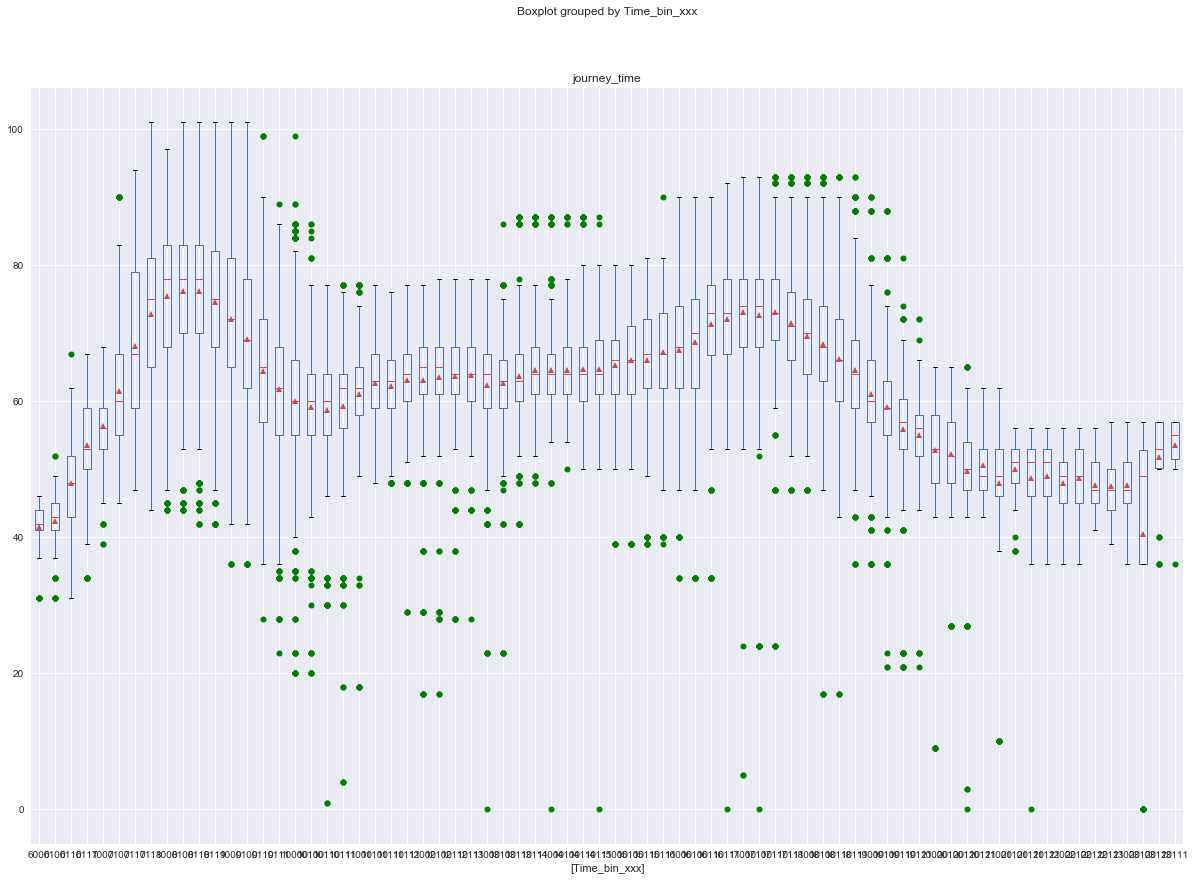

In [69]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['journey_time'], by=['Time_bin_xxx'], showmeans=True, flierprops=flierprops, figsize=(20,14))
plt.savefig('Temp_to_late.pdf')

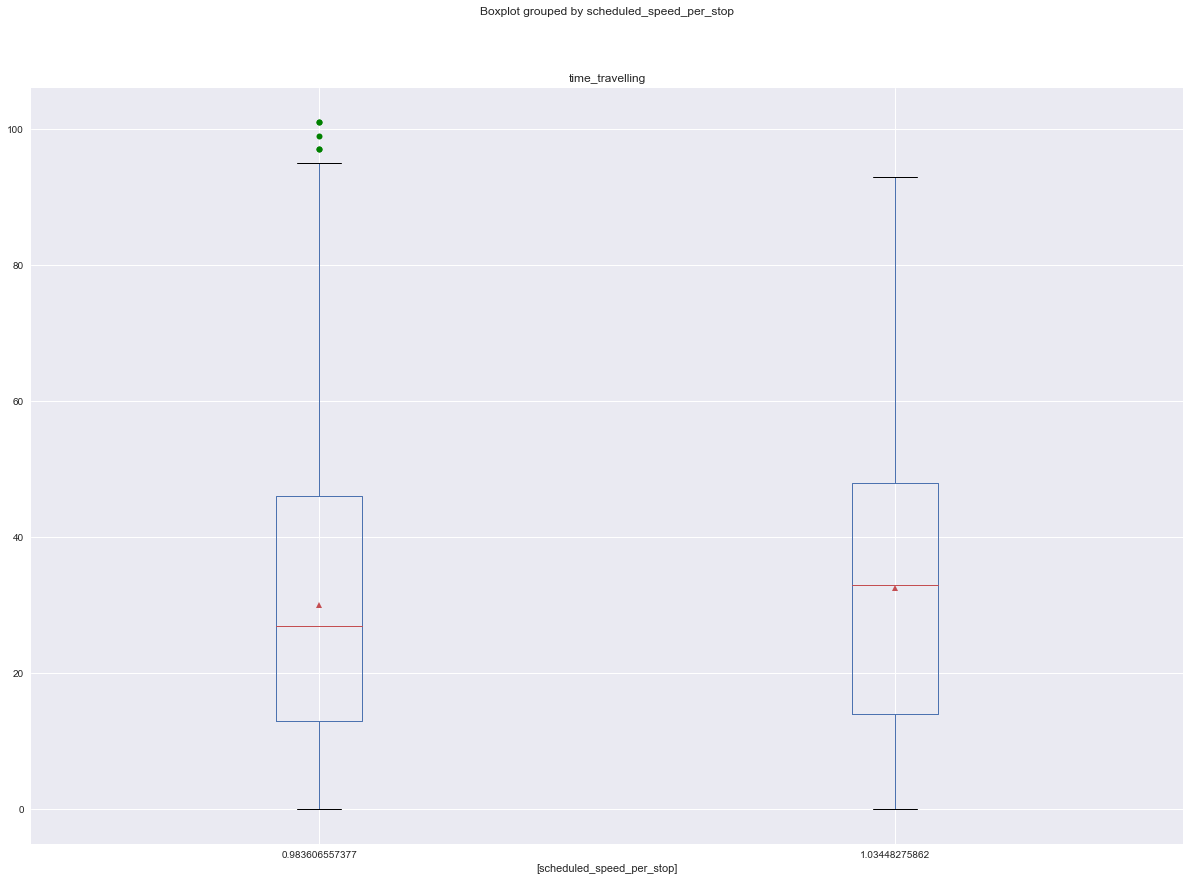

In [70]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['time_travelling'], by=['scheduled_speed_per_stop'], showmeans=True, flierprops=flierprops, figsize=(20,14))
plt.savefig('Temp_to_late.pdf')

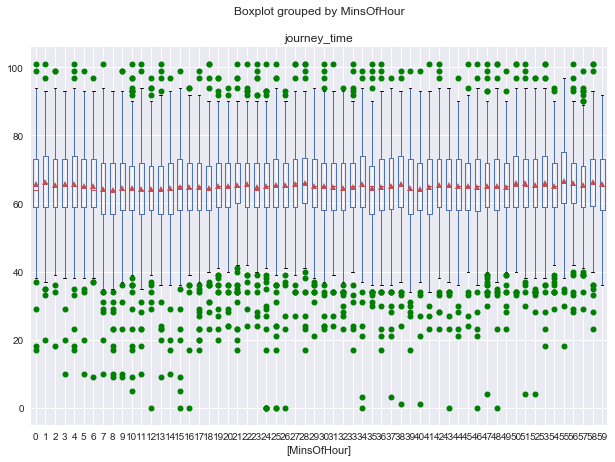

In [71]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['journey_time'], by=['MinsOfHour'], showmeans=True, flierprops=flierprops, figsize=(10,7))
plt.savefig('Mins_to_journey_time.pdf')

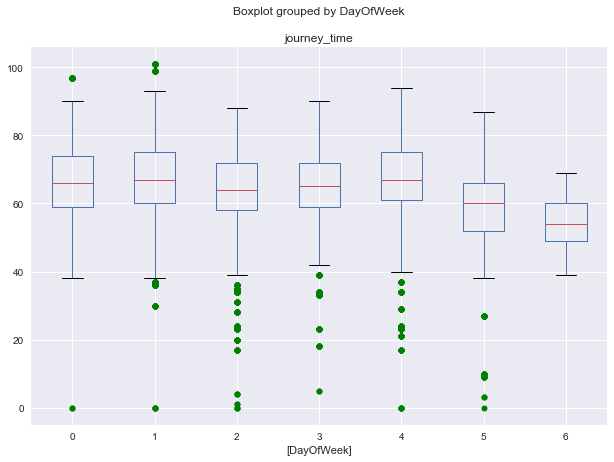

In [72]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['journey_time'], by=['DayOfWeek'], flierprops=flierprops, figsize=(10,7))
plt.savefig('Rain_to_DayOfWeek_chart.pdf')

What is this telling us that there are absolutely no outliers here?

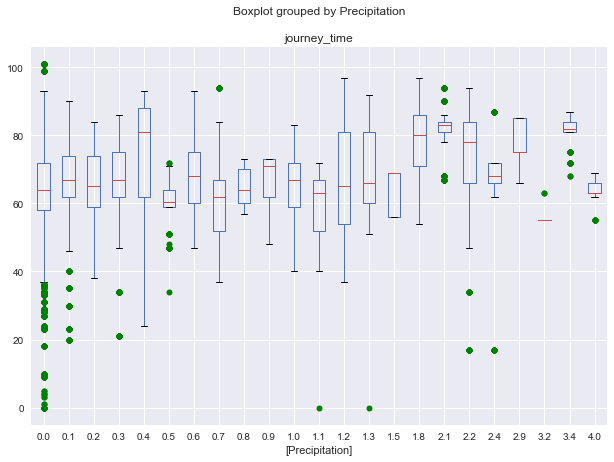

In [73]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['journey_time'], by=['Precipitation'], flierprops=flierprops, figsize=(10,7))
plt.savefig('Rain_to_late.pdf')

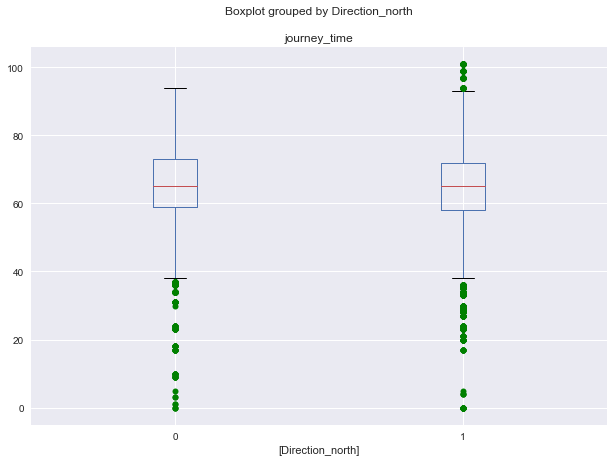

In [74]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['journey_time'], by=['Direction_north'], flierprops=flierprops, figsize=(10,7))
plt.savefig('Journey_Pattern_ID_to_late.pdf')

Represents direction

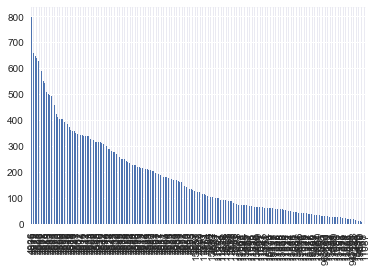

In [75]:
df.Vehicle_Journey_ID.value_counts().plot(kind='bar')

More buses running certain vehicle journey IDs

In [76]:
df.Vehicle_Journey_ID.unique()

array([ 15475,  15488,  15480,  15493,  15483,   4894,   4905,   4542,
         4951,   4572,   4585,   4936,   4915,   4906,   4952,   4543,
         4575,   4558,   4601,   4925,   4586,   4573,   4916,   4559,
         4587,   4917,   4954,   4545,   4577,   4918,   4898,   4546,
         4561,   4928,   4940,   4956,   4579,   4590,   4929,   4920,
         4900,   4957,   4591,   4930,   4942,   4549,   4592,   4902,
         4913,   4959,   4933,   4582,   4593,   4903,   4934,   4945,
         4904,   4946,   4568,   4949,   4555,   4895,   4937,   4896,
         4544,   4926,   4938,   4897,   4560,   4588,   4919,   4547,
         4562,   4548,   4563,   4564,   4565,   4932,   4944,   4923,
         4914,   4583,   4924,   4935,   4948,   4553,   4597,   4554,
         4557,   4907,   4576,   4908,   4927,   4955,   4910,   4899,
         4911,   4580,   4958,   4550,   4594,   4595,   4947,   4567,
         4570,  11064,  11078,  11346,  11066,  11347,  11079,  11067,
      

import statsmodels.formula.api as sm

# Train all continuous features.
check1 = sm.ols(formula="journey_time ~ Proper_rain", data=df).fit()
# Print the weights learned for each feature.
print(check1.summary())

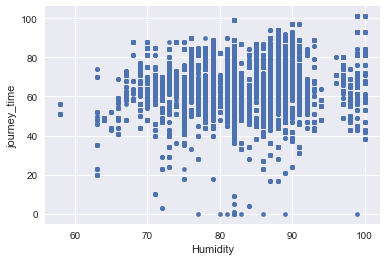

In [77]:
df.plot(kind = 'scatter', y='journey_time', x='Humidity')

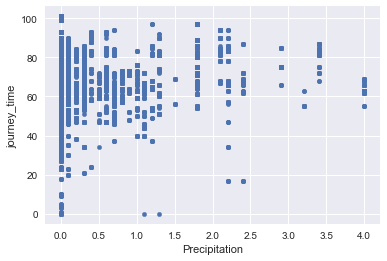

In [78]:
df.plot(kind = 'scatter', y='journey_time', x='Precipitation')

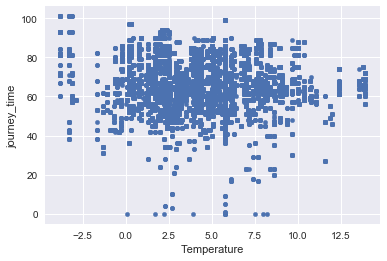

In [79]:
df.plot(kind = 'scatter', y='journey_time', x='Temperature')

In [80]:
df_check_journey_ID = df.loc[df['mins_late'] > 1]
df_check_journey_ID = df_check_journey_ID[['late','Vehicle_Journey_ID']]
df_check_journey_ID.Vehicle_Journey_ID.unique()

array([ 4585,  4906,  4543,  4575,  4601,  4925,  4586,  4917,  4954,
        4545,  4918,  4898,  4561,  4928,  4579,  4929,  4920,  4900,
        4591,  4942,  4549,  4592,  4902,  4913,  4959,  4933,  4593,
        4903,  4936,  4895,  4952,  4558,  4916,  4937,  4544,  4587,
        4938,  4577,  4560,  4588,  4940,  4919,  4547,  4562,  4563,
        4564,  4565,  4932,  4944,  4914,  4915,  4907,  4576,  4908,
        4927,  4955,  4899,  4911,  4580,  4930,  4958,  4550,  4594,
        4923, 11080, 11349, 11093, 11339, 11083, 15664, 15489,  4951,
        4897,  4939,  4590,  4548,  4943,  4582,  4573,  4953,  4546,
        4910,  4912,  4896,  4926,  4581,  4931,  4572,  4559,  4578,
        4589,  4921,  4909,  4956,  4941,  4957,  4901,  4922,  4934,
       11353, 11091, 11092, 11338, 11350, 11070, 11351, 11094, 11071,
       11357, 11095, 11085, 15663, 15488,  4905,  4542,  4960,  4551,
        4566, 11336, 11348, 11337,  4574,  4583,  4945,  4584, 11335,
       11347, 11090,

If Vehicle Journey ID starts with 9 it is never late

In [81]:
df_check_2 = df.loc[(df.Vehicle_Journey_ID == 4585) & (df.Stop_ID == '7226')]
df_check_2.Time

303     2013-01-02 08:22:59
1601    2013-01-03 08:21:18
3187    2013-01-04 08:29:35
5885    2013-01-07 08:41:04
10754   2013-01-10 08:30:42
12412   2013-01-11 08:41:11
15466   2013-01-14 08:41:52
16871   2013-01-15 08:39:06
22001   2013-01-18 08:35:24
24446   2013-01-21 08:41:30
25925   2013-01-22 08:32:19
27480   2013-01-23 08:42:54
32880   2013-01-28 08:38:46
34246   2013-01-29 08:43:20
Name: Time, dtype: datetime64[ns]

(0, 100)

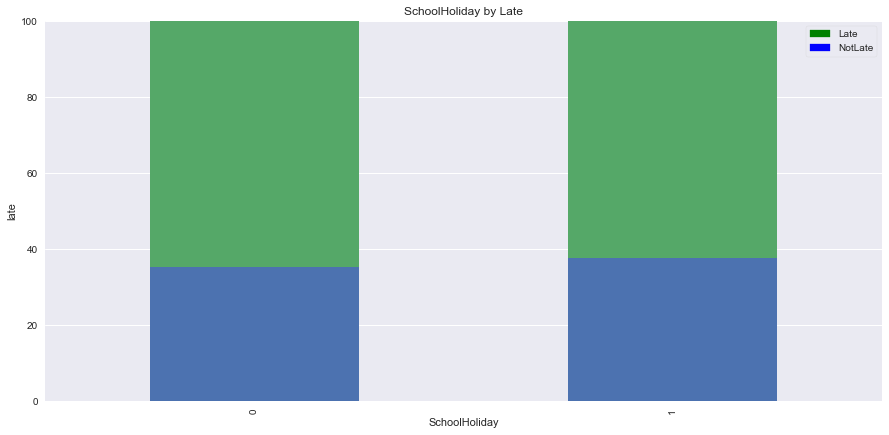

In [82]:
SchoolHoliday = pd.unique(df.SchoolHoliday.ravel())

# Insert a new column called 'percent' and fill it with 0s
df['percent'] = 0

for p in SchoolHoliday:
    count = 1 / df[df.SchoolHoliday == p].count()['late']
    index_list = df[df['SchoolHoliday'] == p].index.tolist()
    for i in index_list:
        df.loc[i, 'percent'] = count * 100
        
# Group dataframe and sum percent
group = df[['percent','SchoolHoliday','late']].groupby(['SchoolHoliday','late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="SchoolHoliday by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("SchoolHoliday")
my_plot.set_ylabel("late")
my_plot.set_ylim([0,100])

(0, 100)

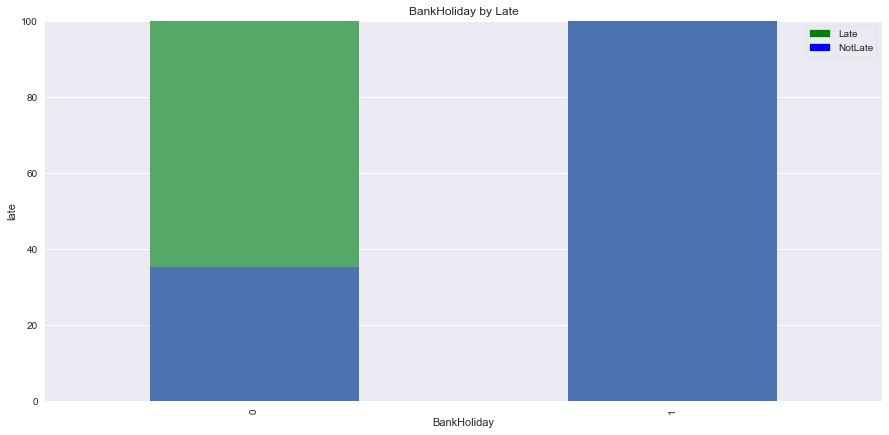

In [83]:
BankHoliday = pd.unique(df.BankHoliday.ravel())

# Insert a new column called 'percent' and fill it with 0s
df['percent'] = 0

for p in BankHoliday:
    count = 1 / df[df.BankHoliday == p].count()['late']
    index_list = df[df['BankHoliday'] == p].index.tolist()
    for i in index_list:
        df.loc[i, 'percent'] = count * 100
        
# Group dataframe and sum percent
group = df[['percent','BankHoliday','late']].groupby(['BankHoliday','late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="BankHoliday by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("BankHoliday")
my_plot.set_ylabel("late")
my_plot.set_ylim([0,100])

(0, 100)

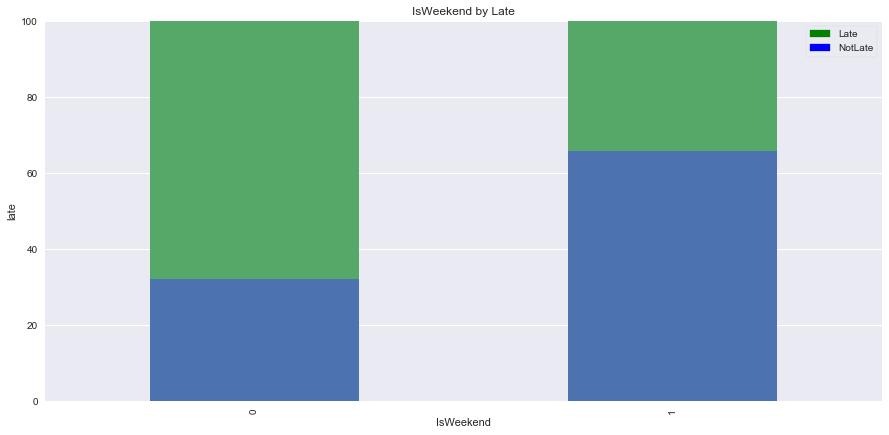

In [84]:
IsWeekend = pd.unique(df.IsWeekend.ravel())

# Insert a new column called 'percent' and fill it with 0s
df['percent'] = 0

for p in SchoolHoliday:
    count = 1 / df[df.IsWeekend == p].count()['late']
    index_list = df[df['IsWeekend'] == p].index.tolist()
    for i in index_list:
        df.loc[i, 'percent'] = count * 100
        
# Group dataframe and sum percent
group = df[['percent','IsWeekend','late']].groupby(['IsWeekend','late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="IsWeekend by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("IsWeekend")
my_plot.set_ylabel("late")
my_plot.set_ylim([0,100])

(0, 100)

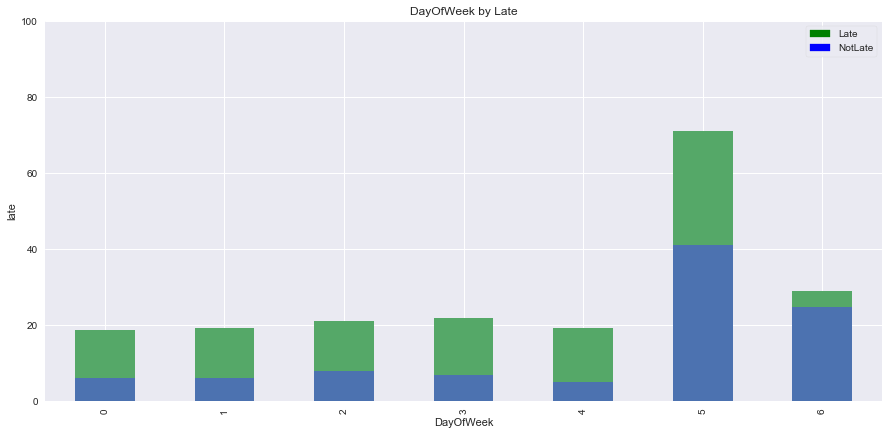

In [85]:
# Group dataframe  and sum percent
group = df[['percent','DayOfWeek','late']].groupby(['DayOfWeek','late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="DayOfWeek by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("DayOfWeek")
my_plot.set_ylabel("late")
my_plot.set_ylim([0,100])

(0, 100)

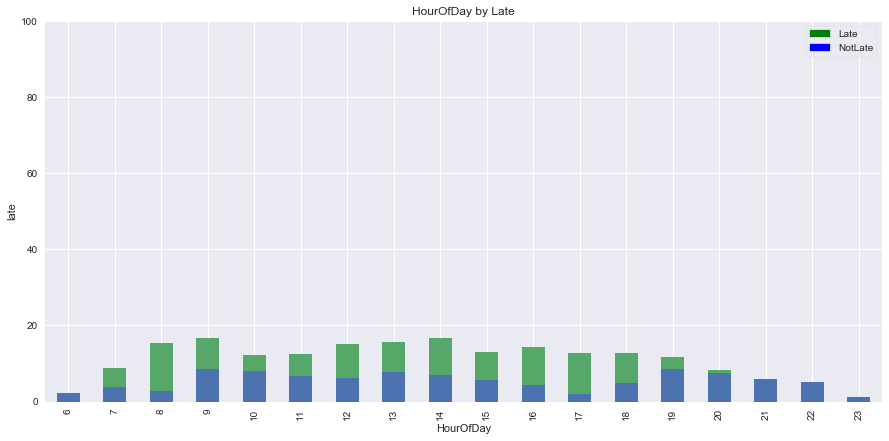

In [86]:
# Group dataframe and sum percent
group = df[['percent','HourOfDay','late']].groupby(['HourOfDay','late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="HourOfDay by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("HourOfDay")
my_plot.set_ylabel("late")
my_plot.set_ylim([0,100])

In [87]:
bins=[10,20,30,40,50,60,70,80,90,100,110]

In [88]:
df['time_bins'] = np.digitize(df.journey_time.values, bins=bins)
df.time_bins.unique()

array([ 4,  5,  6,  7,  3,  0,  8,  9,  2,  1, 10])

In [89]:
df.shape

(36975, 59)

In [90]:
df_check_journey_time = df.loc[df['journey_time'] < 20]
df_check_journey_time = df_check_journey_time[['journey_time','Vehicle_Journey_ID', 'Time', 'stop_order', 'Stop_ID', 'end_time']]
df_check_journey_time.sort_values(['journey_time'], ascending=[True])

,journey_time,Vehicle_Journey_ID,Time,stop_order,Stop_ID,end_time
4691,0.0,4570,2013-01-04 23:24:44,1,324,1357341884000000
31093,0.0,4580,2013-01-25 14:46:13,1,324,1359125173000000
35500,0.0,4570,2013-01-29 23:26:05,1,324,1359501965000000
36394,0.0,4570,2013-01-30 23:24:54,1,324,1359588294000000
22810,0.0,4902,2013-01-18 16:48:11,1,7330,1358527691000000
18360,0.0,4570,2013-01-15 23:24:51,1,324,1358292291000000
16526,0.0,4570,2013-01-14 23:25:08,1,324,1358205908000000
14756,0.0,11087,2013-01-12 21:43:34,1,324,1358027014000000
13887,0.0,4904,2013-01-11 20:34:46,2,332,1357936486000000
26363,0.0,4547,2013-01-22 13:15:29,1,324,1358860529000000


# 4.0 Save DF to be used in Model Analysis

In [91]:
# Save cleaned dataframe to new CSV file
df.to_csv('csv_data/bus_route4_clean.csv', index=False)

---

In [92]:
df_train = df[:130000]

In [93]:
df_test = df[130000:]

df_group = df.groupby(['Vehicle_Journey_ID', 'Start_date'])